In [1]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score

from FinanceData import get_finance_data

# https://www.kaggle.com/code/kellibelcher/jpx-stock-market-analysis-prediction-with-lgbm


In [2]:
colors = [
    "#ef4444",  # 0
    "#f97316",  # 1
    "#f59e0b",  # 2
    "#eab308",  # 3
    "#84cc16",  # 4
    "#22c55e",  # 5
    "#10b981",  # 6
    "#14b8a6",  # 7
    "#06b6d4",  # 8
    "#0ea5e9",  # 9
    "#3b82f6",  # 10
    "#6366f1",  # 11
    "#8b5cf6",  # 12
    "#a855f7",  # 13
    "#d946ef",  # 14
    "#ec4899",  # 15
    "#f43f5e",  # 16
    "#f3f4f6",  # 17
    "#d1d5db",  # 18
    "#6b7280",  # 19
    "#374151",  # 20
    "#111827",  # 21
]


def rgb_to_float(rgb):
    r = int(rgb[1:3], 16) / 255.0
    g = int(rgb[3:5], 16) / 255.0
    b = int(rgb[5:7], 16) / 255.0

    return (r, g, b)


color_pal = list(map(rgb_to_float, colors))


In [83]:
df = get_finance_data("000660")
df.drop("Date", inplace=True, axis=1)

df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-11-23,86100,86700,84900,85200,1480400,0.000000
2022-11-24,86900,87200,85700,86900,2148255,0.019953
2022-11-25,87200,87300,85100,85100,1439011,-0.020713
2022-11-28,84100,84200,82900,83100,2471506,-0.023502
2022-11-29,82700,83700,82100,83500,732691,0.004813


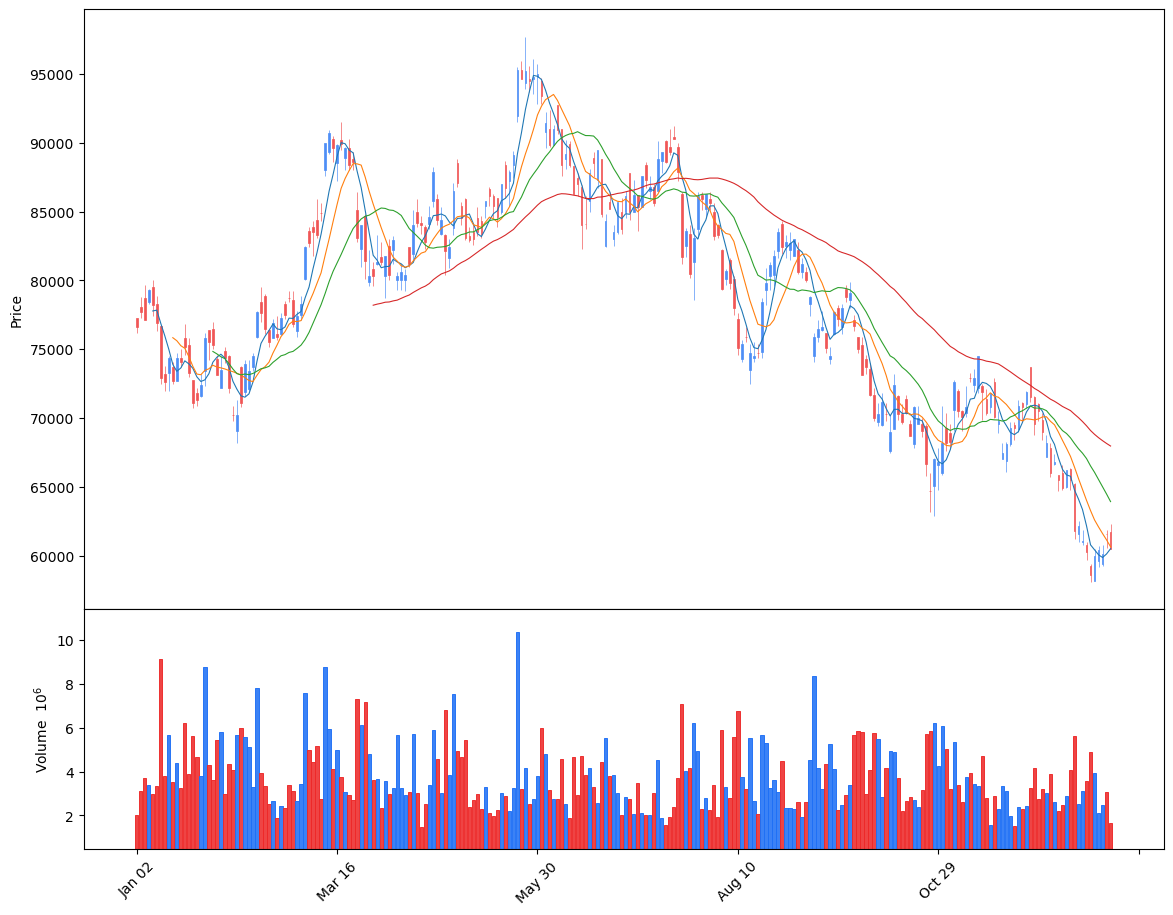

In [4]:
one_year_df = df.loc[(df.index >= "2018-01-01") & (df.index <= "2018-12-30")]

mpf_mc = mpf.make_marketcolors(
    up=colors[10],
    down=colors[0],
    inherit=True
)

mpf_style = mpf.make_mpf_style(marketcolors=mpf_mc)

mpf.plot(one_year_df, type="candle", style=mpf_style, mav=(5, 10, 20, 60), volume=True, figsize=(15, 12))

In [5]:
def rsi(df, n=14):
    close = df["Close"]
    delta = close.diff()[1:]
    
    prices_up = delta.copy()
    prices_down = delta.copy()
    
    prices_up[prices_up < 0] = 0
    prices_down[prices_down > 0] = 0
    
    roll_up = prices_up.rolling(n).mean()
    roll_down = prices_down.abs().rolling(n).mean()
    
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))
    
    return rsi

In [6]:
def create_features(df):
    # df = df.drop(columns=["Open", "High", "Low", "Adj Close"])
    df = df.drop(columns=["Open", "High", "Low", "Change"])
    
    df["EMA_9"] = df["Close"].ewm(9).mean().shift()
    
    sma_periods = [5, 10, 20, 30, 60]
    
    for period in sma_periods:
        df[f"SMA_{period}"] = df["Close"].rolling(period).mean().shift()
        
    df["RSI"] = rsi(df).fillna(0)

    EMA_12 = pd.Series(df["Close"].ewm(span=12, min_periods=12).mean())
    EMA_26 = pd.Series(df["Close"].ewm(span=26, min_periods=26).mean())

    df["MACD"] = pd.Series(EMA_12 - EMA_26)
    df["MACD_signal"] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())
    
    df = df.loc[df.index >= "2001-01-01"]
    
    return df

In [84]:
df_raw = df.copy().loc[df.index >= "2001-01-01"]
df = create_features(df)
df.tail()

,Close,Volume,EMA_9,SMA_5,SMA_10,SMA_20,SMA_30,SMA_60,RSI,MACD,MACD_signal
Date,,,,,,,,,,,
2022-11-23,85200,1480400,88414.752254,87820.0,89340.0,87660.0,89583.333333,89480.000000,55.656109,-661.997633,-347.030835
2022-11-24,86900,2148255,88093.277028,86560.0,88940.0,87225.0,89290.000000,89331.666667,55.454545,-677.986860,-413.222040
2022-11-25,85100,1439011,87973.949325,86400.0,88720.0,87070.0,89023.333333,89195.000000,46.788991,-826.377429,-495.853118
2022-11-28,83100,2471506,87686.554393,85740.0,87880.0,87155.0,88676.666667,89071.666667,39.823009,-1092.764600,-615.235414
2022-11-29,83500,732691,87227.898954,85100.0,87100.0,87175.0,88273.333333,88903.333333,36.744186,-1257.110508,-743.610433


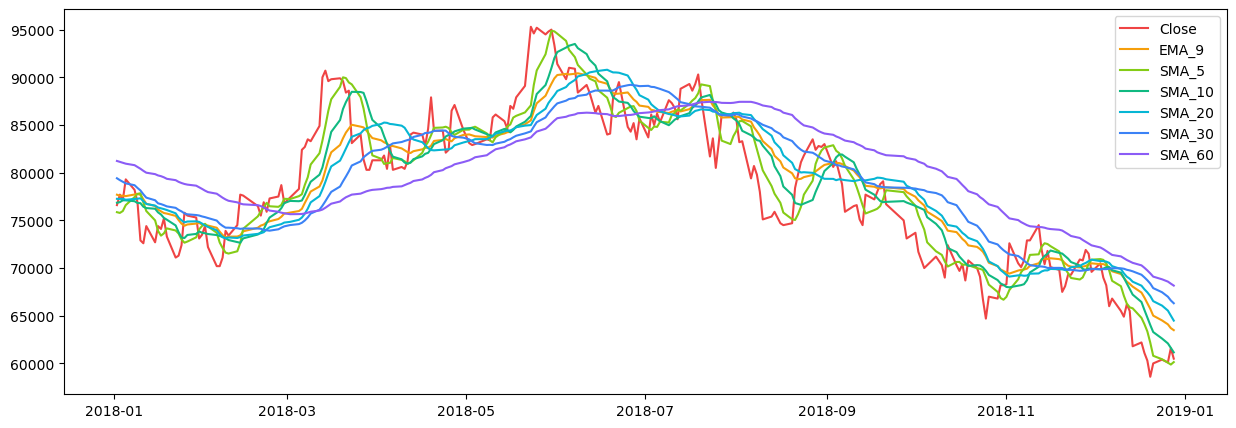

In [8]:
one_year_df = df.loc[(df.index >= "2018-01-01") & (df.index <= "2018-12-31")]

plt.plot(one_year_df["Close"], color=color_pal[0], label="Close")
plt.plot(one_year_df["EMA_9"], color=color_pal[2], label="EMA_9")
plt.plot(one_year_df["SMA_5"], color=color_pal[4], label="SMA_5")
plt.plot(one_year_df["SMA_10"], color=color_pal[6], label="SMA_10")
plt.plot(one_year_df["SMA_20"], color=color_pal[8], label="SMA_20")
plt.plot(one_year_df["SMA_30"], color=color_pal[10], label="SMA_30")
plt.plot(one_year_df["SMA_60"], color=color_pal[12], label="SMA_60")
plt.legend()

fig = plt.gcf()
fig.set_size_inches(15, 5, forward=True)

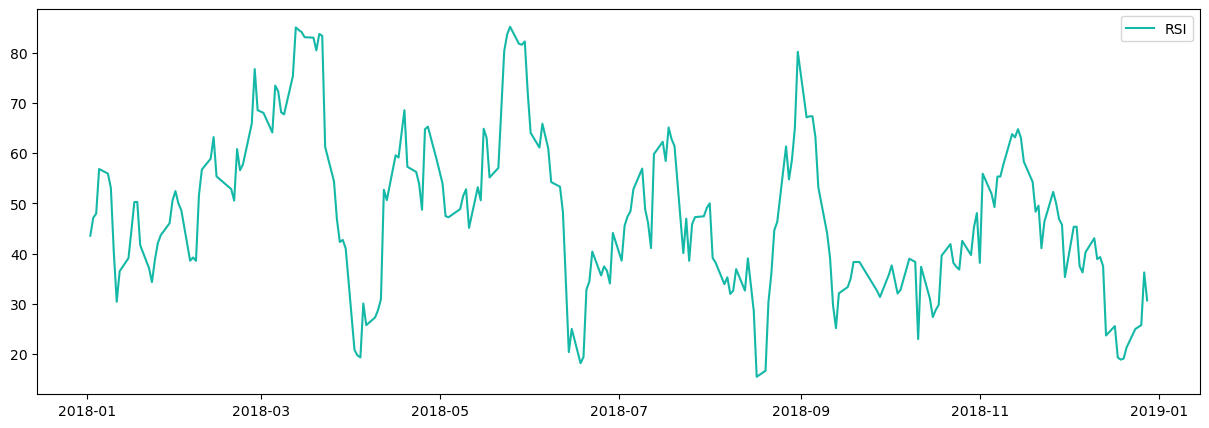

In [9]:
plt.plot(one_year_df["RSI"], color=color_pal[7], label="RSI")
plt.legend()

fig = plt.gcf()
fig.set_size_inches(15, 5, forward=True)

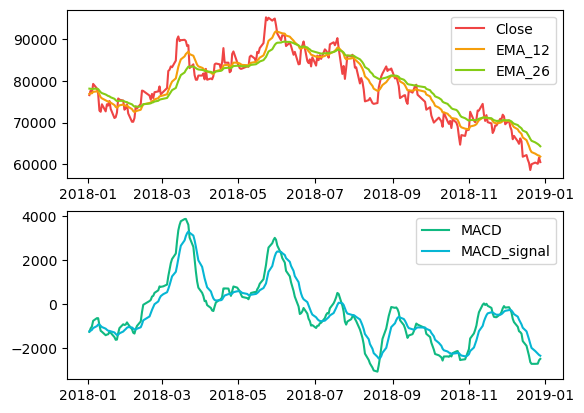

In [10]:
EMA_12 = pd.Series(df["Close"].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df["Close"].ewm(span=26, min_periods=26).mean())

one_year_EMA_12 = EMA_12.loc[(df.index >= "2018-01-01") & (df.index <= "2018-12-31")]
one_year_EMA_26 = EMA_26.loc[(df.index >= "2018-01-01") & (df.index <= "2018-12-31")]

fix, axs = plt.subplots(2)

axs[0].plot(one_year_df["Close"], color=color_pal[0], label="Close")
axs[0].plot(one_year_EMA_12, color=color_pal[2], label="EMA_12")
axs[0].plot(one_year_EMA_26, color=color_pal[4], label="EMA_26")
axs[0].legend()

axs[1].plot(one_year_df["MACD"], color=color_pal[6], label="MACD")
axs[1].plot(one_year_df["MACD_signal"], color=color_pal[8], label="MACD_signal")
axs[1].legend()

fig.set_size_inches(20, 10, forward=True)

In [11]:
train_df = df.loc[df.index < "2018-01-01"].copy()
valid_df = df.loc[("2018-01-01" <= df.index) & (df.index < "2019-07-01")].copy()
test_df = df.loc[("2019-07-01" <= df.index) & (df.index < "2021-01-01")].copy()

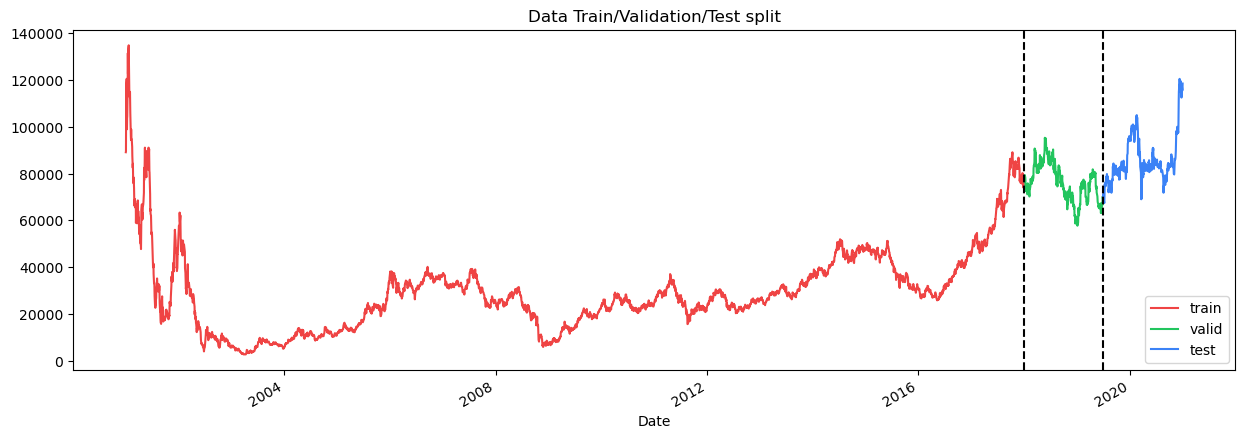

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
train_df.Close.plot(ax=ax, color=color_pal[0], label="train", title="Data Train/Validation/Test split")
valid_df.Close.plot(ax=ax, color=color_pal[5], label="valid")
test_df.Close.plot(ax=ax, color=color_pal[10], label="test")
ax.axvline("2018-01-01", color="black", ls="--")
ax.axvline("2019-07-01", color="black", ls="--")
plt.legend()
plt.show()

In [13]:
y_train = train_df["Close"].copy()
X_train = train_df.drop(["Close"], axis=1)

y_valid = valid_df["Close"].copy()
X_valid = valid_df.drop(["Close"], axis=1)

y_test = test_df["Close"].copy()
X_test = test_df.drop(["Close"], axis=1)

In [14]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)
lgb_test = lgb.Dataset(X_test, label=y_test)

In [15]:
param = {
    "n_estimators": 2000,
    "force_col_wise": "true",
    "objective": "regression",
    "boosting": "gbdt",
    "learning_rate": 0.01,
    "num_leaves": 80,
    "min_data_in_leaf": 50,
    "tree_learner": "serial",
    "device_type": "cpu",
    "seed": 100,
    "max_depth": 7,
    "subsample": 0.9,
    "lambda_l2": 0.1,
    "min_gain_to_split": 0.1,
    "verbose": 0,
}

tss = TimeSeriesSplit(4)
folds = tss.split(X_train)
cv_res_gen = lgb.cv(
    param, lgb_train, folds=folds, callbacks=[lgb.early_stopping(20)]
)
cv_res_obj = lgb.cv(
    param, lgb_train, folds=tss, callbacks=[lgb.early_stopping(20)]
)

np.testing.assert_allclose(cv_res_gen["l2-mean"], cv_res_obj["l2-mean"])


c:\Users\thinl\scoop\apps\mambaforge\current\envs\ai-final\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [16]:
print('Current parameters:\n', param)
print('\nBest num_boost_round:', len(cv_res_gen['l2-mean']))
print('Best CV score:', cv_res_gen['l2-mean'][-1])

Current parameters:
 {'n_estimators': 2000, 'force_col_wise': 'true', 'objective': 'regression', 'boosting': 'gbdt', 'learning_rate': 0.01, 'num_leaves': 80, 'min_data_in_leaf': 50, 'tree_learner': 'serial', 'device_type': 'cpu', 'seed': 100, 'max_depth': 7, 'subsample': 0.9, 'lambda_l2': 0.1, 'min_gain_to_split': 0.1, 'verbose': 0}

Best num_boost_round: 424
Best CV score: 3370473.671561403


In [17]:
model = lgb.train(param, lgb_train, 1000, lgb_valid, callbacks=[lgb.early_stopping(20)])

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

c:\Users\thinl\scoop\apps\mambaforge\current\envs\ai-final\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [18]:
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

In [19]:
mse = mean_squared_error(y_test, predict_test)
r2 = r2_score(y_test, predict_test)

print(f"MSE: {mse}, R2 Score: {r2}")

MSE: 60479686.64443363, R2 Score: 0.43300856976326574


In [20]:
final_result = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(predict_test)], axis=1)
final_result.columns = ['Close', 'Predict']
final_result.index = y_test.index

final_result

,Close,Predict
Date,,
2019-07-01,70000,68502.272121
2019-07-02,71400,69266.795983
2019-07-03,69100,70054.609963
2019-07-04,70200,70044.296566
2019-07-05,68400,70049.606264
...,...,...
2020-12-23,116000,91031.992323
2020-12-24,118000,91031.992323
2020-12-28,115500,90229.982483


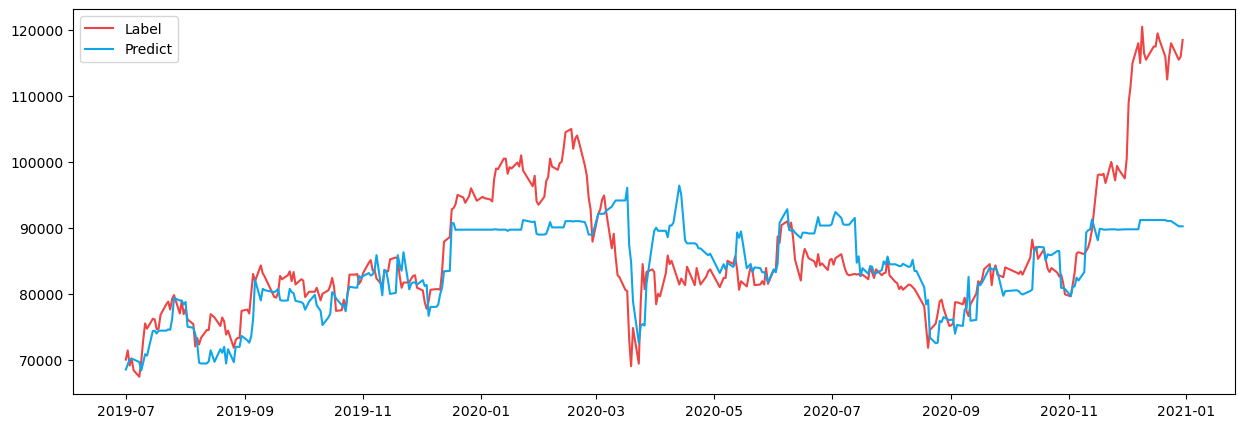

In [21]:
plt.plot(final_result["Close"], color=color_pal[0], label="Label")
plt.plot(final_result["Predict"], color=color_pal[9], label="Predict")
plt.legend()

fig = plt.gcf()
fig.set_size_inches(15, 5, forward=True)

In [122]:
def backtest(backtest_df):
    # backtest_df["Open"] = df_raw["Open"].loc[("2019-07-01" <= df_raw.index) & (df_raw.index < "2021-01-01")]
    # backtest_df["High"] = df_raw["High"].loc[("2019-07-01" <= df_raw.index) & (df_raw.index < "2021-01-01")]
    # backtest_df["Low"] = df_raw["Low"].loc[("2019-07-01" <= df_raw.index) & (df_raw.index < "2021-01-01")]

    backtest_df["range"] = backtest_df["High"] - backtest_df["Low"]
    backtest_df["range"] = backtest_df["range"].shift(1)

    backtest_df["noise"] = 1 - abs(
        (backtest_df["Open"] - backtest_df["Close"]) / (backtest_df["High"] - backtest_df["Low"])
    )
    backtest_df["noise"].shift(1)
    backtest_df["noise_mean"] = backtest_df["noise"].rolling(20).mean().shift()

    # backtest_df["target"] = backtest_df["Open"] + backtest_df["range"] * backtest_df["noise_mean"]
    backtest_df["target"] = backtest_df["Open"] + backtest_df["range"] * 0.8
    
    # fee = 0.003
    fee = 0.00
    backtest_df["ror"] = np.where(backtest_df["High"] > backtest_df["target"], backtest_df["Close"] / backtest_df["target"] - fee, 1)

    return backtest_df


In [123]:
raw_bt = backtest(df_raw.copy())
raw_bt.head()

,Open,High,Low,Close,Volume,Change,range,noise,noise_mean,target,ror
Date,,,,,,,,,,,
2001-01-02,76556,89904,76556,89118,19790590,0.127947,NaN,0.058885,NaN,NaN,1.000000
2001-01-03,86174,93241,84800,89511,29071000,0.004410,13348.0,0.604668,NaN,96852.4,1.000000
2001-01-04,102859,102859,99522,102859,23582200,0.149121,8441.0,1.000000,NaN,109611.8,1.000000
2001-01-05,105019,118170,102859,118170,29973110,0.148854,3337.0,0.141075,NaN,107688.6,1.097331
2001-01-08,117778,133089,114637,120525,27148680,0.019929,15311.0,0.851127,NaN,130026.8,0.926924


In [124]:
ror = raw_bt["ror"].cumprod()[-2]
ror

8.30409211224762

In [98]:
backtest_df = backtest(final_result.copy())
ror = backtest_df["ror"].cumprod()[-2]
ror

0.6313949390920252